# Local Interpretability

In this section, three local, model-agnostic interpretability methods are discussed.

Local interpretability allows discussing the output prediction (according to a model) for a given sample. The interpretation methods somehow zoom in on a particular instance, examine what the model predicts for its input values, and explain why. 

The idea is that locally, the prediction might only depend linearly or monotonically on some features, rather than on more complex combination. However, the methods are often heavier to compute and understand than more straightforward methods such as the ones from the previous sections. 

These three models are:

1. The individual conditional expectation {cite}`goldstein2015peeking` (ICE), which is a local version of PDP (see the previous section). 
2. The second method is LIME {cite}`ribeiro2016should`, which stands for Local Interpretable Model-agnostic Explanations. 
3. The third method is SHAP {cite}`NIPS2017_7062`, which stands for SHapley Additive exPlanations. In addition, TreeSHAP and DeepSHAP, two model-specific versions of SHAP are also discussed.

## The individual conditional expectation (ICE)

PDP displays the overall behavior of the model's prediction when a feature from set $S$ changes.

ICE does the same but displays one curve per instance. 

Therefore, PDP is no more than the average of the lines of an ICE plot {cite}`molnar2019`. 

PDP is a global method, where ICE is a local method. 

In ICE plots, for each instance $i$ in $\{(x^{(i)}_S,x^{(i)}_C)\}^N_{i=1}$ a curve $\hat{f}(i)$ is plotted against $x^{(i)}_S$, while $x^{(i)}_C$ remains fixed. 

To clearly highlight the difference between PDP and ICE, recall the toy example from the PDP section.

| F1  | F2  | F3  |  Y  |
|:---:|:---:|:---:|:---:|
| $x_{11}$ | $x_{12}$ | $x_{13}$ |  $\hat{y_{1}}$ |
| $x_{21}$ | $x_{22}$ | $x_{23}$ |  $\hat{y_{2}}$ |
| $x_{31}$ | $x_{32}$ | $x_{33}$ |  $\hat{y_{3}}$ |

Here again, we consider $X_S$ to be **F1**. Both PDP and ICE make copies of the samples, duplicating each possible **F1** value for the full dataset.

| F1  | F2  | F3  |  Y  |
|:---:|:---:|:---:|:---:|
| $x_{11}$ | $x_{12}$ | $x_{13}$ |  $\hat{y_{11}}$ |
| $x_{11}$ | $x_{22}$ | $x_{23}$ |  $\hat{y_{12}}$ |
| $x_{11}$ | $x_{32}$ | $x_{33}$ |  $\hat{y_{13}}$ |
| $x_{21}$ | $x_{12}$ | $x_{13}$ |  $\hat{y_{21}}$ |
| $x_{21}$ | $x_{22}$ | $x_{23}$ |  $\hat{y_{22}}$ |
| $x_{21}$ | $x_{32}$ | $x_{33}$ |  $\hat{y_{23}}$ |
| $x_{31}$ | $x_{12}$ | $x_{13}$ |  $\hat{y_{31}}$ |
| $x_{31}$ | $x_{22}$ | $x_{23}$ |  $\hat{y_{32}}$ |
| $x_{31}$ | $x_{32}$ | $x_{33}$ |  $\hat{y_{33}}$ |

Remember that PDP displays only one curve: $[x_{11},x_{21},x_{31}]$ on the x-axis and $[\frac{\hat{y_{11}}+\hat{y_{12}}+\hat{y_{13}}}{3},\frac{\hat{y_{21}}+\hat{y_{22}}+\hat{y_{23}}}{3},\frac{\hat{y_{31}}+\hat{y_{32}}+\hat{y_{33}}}{3}]$ on the y-axis.
ICE,however, displays three curves, from column '**Y**': 
- curve for sample $[x_{11},x_{12},x_{13}]$ : $[x_{11},x_{21},x_{31}]$ on the x-axis and $[\hat{y_{11}},\hat{y_{21}},\hat{y_{31}}]$ on the y-axis
- curve for sample $[x_{21},x_{22},x_{23}]$ : $[x_{11},x_{21},x_{31}]$ on the x-axis and $[\hat{y_{12}},\hat{y_{22}},\hat{y_{32}}]$ on the y-axis
- curve for sample $[x_{31},x_{32},x_{33}]$ : $[x_{11},x_{21},x_{31}]$ on the x-axis and $[\hat{y_{13}},\hat{y_{23}},\hat{y_{33}}]$ on the y-axis

Unfortunately, ICE has the same independence assumption as PDP. It must therefore be used with a lot of caution when features are correlated.

A concern with partial dependence plots, is that they are plots of averages, they tend to obscure, rather than eluminate individual differences. PDPs give you a coarse view of how the model works.               

An ICE plot enables you to drill down to the level of observations.  
While the PDP average can hide the interesting behavior of a few fraudulent transactions into an ocean of genuine transactions, ICE is more appropriate for fraud detection at the cost of a more complicated plot to interpret.

Visually:

 ![les9_ICE_plots_unpack_the_PD_function](img/les9_ICE_plots_unpack_the_PD_function.png)


In the rest of this section, ICE is put into practice: Our data are first prepared, as in previous sections, and positive and negative samples are also separated.

In [1]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   184k      0 --:--:-- --:--:-- --:--:--  184k


In [2]:
import numpy as np
import pandas as pd
import timeit
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

%run shared_functions.py

# Load data from the 2018-07-25 to the 2018-08-14
DIR_INPUT='./simulated-data-transformed/data/' 

BEGIN_DATE = "2018-07-25"
END_DATE = "2018-09-26"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
end_date_training = datetime.datetime.strptime("2018-07-31", "%Y-%m-%d")

# Delay period
start_date_delay = datetime.datetime.strptime("2018-08-01", "%Y-%m-%d")
end_date_delay = datetime.datetime.strptime("2018-08-07", "%Y-%m-%d")

# Test period
start_date_test = datetime.datetime.strptime("2018-08-08", "%Y-%m-%d")
end_date_test = datetime.datetime.strptime("2018-08-15", "%Y-%m-%d")

# Get the corresponding data
train = transactions_df[transactions_df.TX_DATETIME<end_date_training]
delay = transactions_df[transactions_df.TX_DATETIME>start_date_delay]
delay =           delay[transactions_df.TX_DATETIME<end_date_delay] 
test = transactions_df[transactions_df.TX_DATETIME>start_date_test]

# Build classifier
clf = RandomForestClassifier(random_state=0)

input_features = ['TX_AMOUNT', 'TX_DURING_NIGHT', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW']
input_features_small = ['AMOUNT', 'NIGHT', 'AVA1D', 'AVA30D']
output_feature = "TX_FRAUD"

# Train classifier
model_and_predictions_dictionary = fit_model_and_get_predictions(clf, train, test, 
                                                                 input_features, output_feature, scale=False)

test['predictions']=model_and_predictions_dictionary['predictions_test']
    
performance_assessment(test, top_k_list=[50])

Load  files
CPU times: user 104 ms, sys: 274 ms, total: 378 ms
Wall time: 1.36 s
613550 transactions loaded, containing 5500 fraudulent transactions


AUC ROC  Average precision  Card Precision@50
0    0.665              0.303              0.154

In [4]:
train1 = train[train.TX_FRAUD==1]
train0 = train[train.TX_FRAUD==0]
train01 = pd.concat([train1, train0.sample(train1.shape[0],random_state=0)], axis=0)
train01.shape

(1032, 23)

In [5]:
test1 = test[test.TX_FRAUD==1]
test0 = test[test.TX_FRAUD==0]
test01 = pd.concat([train1, test0.sample(test1.shape[0],random_state=0)], axis=0)
test01.shape

(4792, 24)

The ICE methods is also implemented by the `PartialDependenceDisplay` function used before, by specifying the parameter `kind` to `'individual'` parameter. In this example, a balanced (genuines vs. frauds) set of transactions is used.

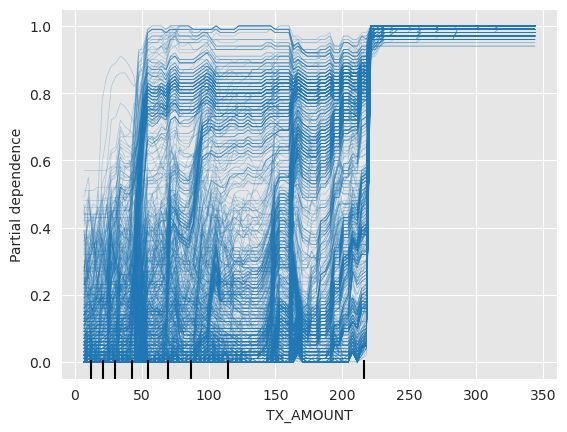

In [6]:
from sklearn.inspection import PartialDependenceDisplay
pdp = PartialDependenceDisplay.from_estimator(clf, X=train01[input_features], features=['TX_AMOUNT'],
                        kind='individual')
plt.ylim([-0.05,1.05])
plt.show()

It clearly appears that all transactions, if we force its amount to be >220, will be flagged as fraudulent by the random forest model. For each particular transaction, we can now explain what would have been the output if `TX_AMOUNT` had been different. 

As another illustration, let us compare a transaction with high `TX_AMOUNT` and low `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW` and another transaction with the opposite behavior.

some intreresting_trx : [ 33 104 156 300 385]
intreresting_trx number: [ 33 104 156 300 385]
       TX_AMOUNT  TX_DURING_NIGHT  CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW  \
4223      161.10                0                           68.583333   
11346     161.75                0                           97.135000   
16183     190.95                0                          128.406667   
32175     191.00                0                          133.800000   
42423     183.15                0                           86.853333   

       CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW  
4223                             32.037458  
11346                            30.998235  
16183                            34.074231  
32175                            33.039886  
42423                            20.445833  


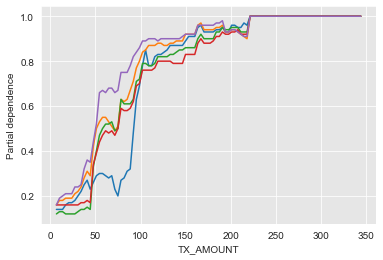

In [8]:
from sklearn.inspection import partial_dependence
pdp_1 = partial_dependence(clf, X=train01[input_features], features=['TX_AMOUNT'],
                        kind='individual')

interesting_trx_1 = np.where((train01.TX_AMOUNT>150)&(train01.TX_AMOUNT<220)&(train01.CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW<35))[0]
print('some intreresting_trx : '+str(interesting_trx_1))

trx_1 = interesting_trx_1#[0]

print('intreresting_trx number: '+str(trx_1))
print(train01[input_features].iloc[trx_1])

#plt.plot(pdp_1.get('values')[0],pdp_1.get('individual')[0,trx_1,:])
plt.plot(pdp_1.get('values')[0],pdp_1.get('individual')[0,trx_1,:].transpose())
plt.xlabel('TX_AMOUNT')
plt.ylabel('Partial dependence')
plt.show()

some intreresting_trx : [327 411 430 818 881]
intreresting_trx number: [327 411 430 818 881]
       TX_AMOUNT  TX_DURING_NIGHT  CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW  \
35609      11.90                0                             113.740   
46059      46.98                0                              53.754   
48162      39.75                1                              53.995   
44848      42.82                0                              42.820   
11957      12.91                0                              54.120   

       CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW  
35609                           105.896286  
46059                           108.809837  
48162                           108.126574  
44848                           107.571579  
11957                           110.717059  


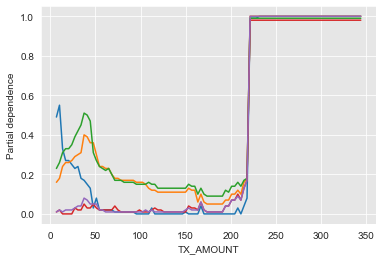

In [9]:
pdp_2 = partial_dependence(clf, X=train01[input_features], features=['TX_AMOUNT'],
                        kind='individual')

interesting_trx_2 = np.where((train01.TX_AMOUNT<50)&(train01.CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW>105))[0]
print('some intreresting_trx : '+str(interesting_trx_2))

trx_2 = interesting_trx_2#[0]

print('intreresting_trx number: '+str(trx_2))
print(train01[input_features].iloc[trx_2])

plt.plot(pdp_2.get('values')[0],pdp_2.get('individual')[0,trx_2,:].transpose())
plt.xlabel('TX_AMOUNT')
plt.ylabel('Partial dependence')
plt.show()

The two last plots confirm that a transaction with high `TX_AMOUNT` and low `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW` (former plot, `pdp_1` in the code) is generally more suspicious than low `TX_AMOUNT` and high `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW` (later plot, `pdp_2` in the code) for the model. Also, in both cases, if a transaction had a `TX_AMOUNT` > 220, it would have been flagged as a fraud.

## Local interpretable model-agnostic explanations (LIME)

LIME is often used with texts and images but can also deal with tabular data. Let us imagine that our model has a complex classification boundary, such as the one in Fig. 1. Local explanations focus on explaining the prediction of a particular sample, the bold red cross in this case. For each sample to be explained, LIME proceeds in two steps:

1. It generates new samples close to the considered sample and gets their predictions using the original model. These new samples are weighted by the proximity of the sample to be explained (as suggested in Fig. 1. by the size of the crosses and circles). The closer the sample, the higher its weight (also, as suggested in Fig. 1). 

2. It trains a linear regression model, represented here by a dashed line, from the new samples and the sample to be explained. This local surrogate model can then be used to provide an explanation as linear models are easily interpretable (even if it is a poor global approximation of the starting model). Usually, the surrogate model is a Lasso regression model or a decision tree. This choice is justified in {cite}`ribeiro2016should`, as it is obvious that there is a trade-off between fidelity (between the model and its surrogate) and interpretability.

More details about the sampling and the training of the surrogate model can be found in {cite}`ribeiro2016should`.



![LIME](img/LIME.png)

<p style="text-align: center;">
Fig. 1. From {cite}`ribeiro2016should`. LIME's step one is a resampling of the dataset and the second step is the training of a surrogate, easily interpretable model. 
</p>


Let us now try LIME on our usual dataset. For the LIME display, the `input_features` are re-defined to make the feature names shorter.

In [11]:
input_features_shorter = ['TX_AM',
 'TX_NI',
 'AV_AM_1',
 'AV_AM_30']

A LIME explainer is then instantiated. Some information must be provided: some training data (as shown in Fig. 1., numpy format is required), a `mode` flag to specify if our task is classification or regression. `feature_names` and `class_names` are two esthetic parameters. By default, LIME predicts the probability to belong to class 1 (or to be a fraud, in our case) in binary settings.

In [12]:
# ! pip install LIME
import lime.lime_tabular as LIME
explainer = LIME.LimeTabularExplainer(train01[input_features].to_numpy(), mode='classification', 
                        feature_names=input_features_shorter, class_names=['Genuine','Fraud'], random_state = 0)

The strength for LIME (and SHAP), is that the output of the model can be explained for any sample we provide. First, let us interpret a genuine transaction.

In [13]:
i = 0
data = test0[input_features].to_numpy()
exp = explainer.explain_instance(data[i], clf.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)
print('original model (random forest) predicts '+ str(clf.predict_proba(data)[i][1]))
print('surrogate model (LIME) predicts '+ str(exp.intercept[1]+pd.DataFrame(exp.as_list())[1].sum()))
print('surrogate model (LIME) intercept is '+ str(exp.intercept[1]))

original model (random forest) predicts 0.0
surrogate model (LIME) predicts 0.03026456512293968
surrogate model (LIME) intercept is 0.4101635617776679


The `show_in_notebook` function allows to visualise the LIME results. This small report reads as follows:

1. The transaction was predicted as genuine by the original model with really high confidence (left part).
2. The original features values are reported on the right part.
3. On the center part, we have the actual interpretation. The decision is mostly due to the values of the features `TX_AMOUNT`. The local prediction for LIME is the sum of the coefficient plus the intercept of the surrogate model (which can be obtained with exp.intercept[1]). `TX_DURING_NIGHT` is the only feature to add a suspicious contribution. The rest leads to a genuine prediction.

Secondly, let us interpret the first fraudulent transaction (from the test set).

In [14]:
i = 0
data = test1[input_features].to_numpy()
exp = explainer.explain_instance(data[i], clf.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)
print('original model (random forest) predicts '+ str(clf.predict_proba(data)[i][1]))
print('surrogate model (LIME) predicts '+ str(exp.intercept[1]+pd.DataFrame(exp.as_list())[1].sum()))
print('surrogate model (LIME) intercept is '+ str(exp.intercept[1]))

original model (random forest) predicts 0.02
surrogate model (LIME) predicts 0.2529393970713793
surrogate model (LIME) intercept is 0.3331373644131759


Our classifier fails to predict this transaction correctly. Maybe it can be useful to correct the fraud detection model in the future (for example, if a cluster of transactions is systematically misclassified). Let us find a transaction that was flagged as fraudulent by our model with higher confidence:

In [15]:
test1[['TX_FRAUD','predictions']]

TX_FRAUD  predictions
134229         1         0.02
134330         1         0.04
134391         1         0.48
134501         1         0.99
134504         1         0.00
...          ...          ...
613000         1         0.00
613150         1         0.00
613247         1         0.00
613417         1         0.00
613500         1         0.36

[4276 rows x 2 columns]

Transaction number three was predicted with a high confidence. Let us try LIME on it:

In [16]:
i = 3
data = test1[input_features].to_numpy()
exp = explainer.explain_instance(data[i], clf.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)
print('original model (random forest) predicts '+ str(clf.predict_proba(data)[i][1]))
print('surrogate model (LIME) predicts '+ str(exp.intercept[1]+pd.DataFrame(exp.as_list())[1].sum()))
print('surrogate model (LIME) intercept is '+ str(exp.intercept[1]))

original model (random forest) predicts 0.99
surrogate model (LIME) predicts 0.7756366051387164
surrogate model (LIME) intercept is 0.16196521463612154


The classification model predicts the Fraud status of the transaction correctly because of the high value of `TX_AMOUNT` (higher than 220, that fraud was therefore added by scenario 1).

## Shapley values

We explain the use of Shapley values to interprete feature contributions in a black box machine learning model.

This is not the origin of the Shapley value. Shapley was an economist intrerested in game theory. We will focus on the game theoretical context first, to get a grasp of how it works.

![les9_Shapley](img/les9_Shapley.png)

The Shapley value represents the payout for every player in a cooperative game. It can also be used to measure the contribution of a feature to a ML model.

FI, Shapley won the Noble price for his contribution to game theory.

The original context of Shapley tries to access each player's contribution in a cooperative game.

For example: There is an indoor soccer team. The goal is to find out how much each player contributes to the team.

In game theory, this contribution would be the "playoff". We will call it: "the marginal gain" or "the marginal contribution" of each player.

![les9_players_in_a_soccer_team](img/les9_players_in_a_soccer_team.png)

Assume, we have a characteristic function to assess the value of a soccer team.

Adding one player to the team will give it a certain strength. Adding player A, will give the team a value of 6.

v({A}) = 6, where v is called 'characteristic function'.

![les9_player_A](img/les9_player_A.png)

We can try to complete the team by adding extra players. Adding extra players will increase the value of the team. However, players can have overlapping skill sets.

![les9_adding_players_B_and_C](img/les9_adding_players_B_and_C.png)

Say that adding player B with player A, gives us a value of the characteristic funtion of 10.
- add player B
  - v({A})=6,
  - v({A, B}) = 10,
  - B has a marginal contribution of 4.
- add player C
  - v({A, B, C}) = 12,
  - C contributes 2 to the team.
 
Player C only contributes 2 to the team. 

However, if this small value is due to player B, already being in the team before C, then we should take into account what would happen if C came in first.

This is the only fair way to address all players payoffs.
So, if we add C first, her marginal contribution is 4 and that of B is reduced to 2.

![les9_players_in_a_soccer_team](img/les9_players_in_a_soccer_team.png)

If we want to be perfectly fair in our assessment, we should then look at all possible teams we can form with player C to know what value she really adds to the team.

In other words, to know the contribution of C, we need to average her contribution in all formations of the team.

To explain this, we need some combinatorial theory.
Let's first go over some extra intuitions. This will make it easier to explain the math later on.

1. It is important to see that only the players that were already in the team before C, matter. Not the order in which these were added. Whether A came first in the team, it doesn't matther. Thus, we only need to know the value of adding C to a team with A and B once and weigh it with the number of teams we can form with A and B.
2. All players that come after C are not important. But, we need to take into account that we could add players D and E in a different order and it would not impact the marginal contribution of adding C to a team with A and B.

Translate the intuition to a mathematical formula.

![les9_Shapley_values_slide_0](img/les9_Shapley_values_slide_0.png)

Let's break this formula down in little pieces.

We have a team with p players and we want to know the payoff for a player j among those p players. This means we have to look at all possible subsets where we can add player j to the team.

Put differently, we take sets of players out of all p players, not including player j, since this is the one we're adding to the team.

In other words, we consider all possible teams with players A, B, D and E. This can be teams off all possible sizes: AC, ABC, BDC, AEDC, etc.

Know that also the empty set is a subset. This is the value of a team with only C in it.

![les9_Shapley_values_slide_1](img/les9_Shapley_values_slide_1.png)

We saw earlier that the order of the players in the subset didn't matter. However, if we want to the contribution of C over all possible teams she can be aded to, then we need some combinatorial theory to determine the weights. 

Again, remember that C has the same contribution whether the team was AB or BA before she was added. All permutations of players in the team before C are given by the size of S!

(p - |S| - 1) is the number of residual players left after adding C to the subset. So the factorial of this term gives all permutations how we can add these players.

p! is a normalization and corresponds to the total number of teams possible, taking the order into account. This is the denominator of the weights.

The actual contribution of player C (respectively j), is the value of the team with C (respectively J), minus the value of the team without C (respectively j). 

We just need to caluclate this value for all possible teams.

In other words, the Shapley value of player C is her marginal value over all possible sub teams and weighted over all possible permuations of these teams.
![les9_Shapley_values_slide_2](img/les9_Shapley_values_slide_2.png)

Now, let's translate the problem to a machine learning context. Suppose you have trained a machine learning model on your data. We want to know how much each feature contributes to our model's predictions for a specific observation. 

![les9_Shapley_values_in_ML](img/les9_Shapley_values_in_ML.png)

Here, f hat is the estimated function by your machine learning model.
Think of a random forest, neural network or SVM. X_s is the subspace of
features. 

To obtain the estimate of the model over a subset of parameters, you will have to integrate out the other parameters that are not in the subset, in other words, marginalize for the features that are not in the model. 

The contribution is then the difference of this prediction from the average value
or the prediction of the null model. The average value is often just a mean value
of your target in the data, sometimes also called an intercept model. 

Note that if you subtract two value functions for different subsets this baseline term
actually disappears. All possible subsets of feature values have to be evaluated
with and without feature j to calculate the exact Shapley value. 

Obviously, this becomes an exponential problem when there are many features. 

![les9_Shapley_values_slide_3](img/les9_Shapley_values_slide_3.png)

Therefore, an approximation based on Monte Carlo sampling is often used in practice. This approximation samples from the feature space as you can see illustrated. In other words, for every feature j, we sample M times a random permutation of the other features
and calculate the differences in predicted value for a specific observation. The Shapley value is then the average of all these samples. 

Let's illustrate this into somewhat more detail. Here, you can see a worked out example of how to calculate the Shapley value. 


Say we have an observation x (Bart) with features age, income, R for recency, F for
frequency, M for monetary and debt. Assume we want to determine the importance of F
for Bart. We start an iterative procedure for m starting at 1 and going to M.

We draw a random instance z from our data. Say this is Tim. We then choose a random permutation of the features say R, debt, F, age, M and income.

The first table illustrates the values of these features for Bart and Tim. We then
construct two new instances. The first one x+j includes all the values of R, Debt and F for Bart and the values age, M and income for Tim. 

The second instance x-j includes the values of R and debt for Bart and the values
F, age, M and income for Tim. We then calculate phi_j_m as the difference in the prediction of the machine learning model for both x+j and x-j.

Once the iteration has finished, the importance of feature j for x can be calculated as the average of the phi_j_m values.

![les9_Shapley_values_slide_4](img/les9_Shapley_values_slide_4.png)

## Shapley additive explanations (SHAP): KernelSHAP

In the first place, the SHAP authors proposed KernelSHAP, which is model-agnostic, a kernel-based estimation approach for Shapley values inspired by LIME. Actually, LIME can predict the SHAP feature contribution if the SHAP kernel (from now, you can read ''SHAP sampler'') is used for sampling at step 1 of LIME. Then they proposed a wide range of model-dependent explanation models (DeepExplainer, GradientExplainer, LinearExplainer,...) based on the same idea.

The basic idea of KernelSHAP (and SHAP in general) is to explain the prediction of an instance by computing the contribution of each feature to the prediction. These contributions are called the Shapley value and are additive contributions as for LIME. It means that the sum of the Shapley contribution (plus the base value $\phi_0$) directly gives the predicted output of the model $f(x)$ to be explained: 

$$
f(x) = \phi_0 + \displaystyle \sum_{j=1}^{M} \phi_j
$$

where $\phi_j \in R$ is the feature attribution for a feature $j$, also called the Shapley value(s) in game theory. The feature contributions must add up to the difference of prediction for $x$ and the average prediction $\phi_0$, also called base value. In this sense, it is closely related to LIME.


What is the point of using SHAP instead of LIME? SHAP has three desirable theoretical properties {cite}`molnar2019` {cite}`NIPS2017_7062`:

1. Local accuracy: The feature contributions $\phi_j$'s add up to the prediction difference for $x$ and the average predicted value, as in the previous equation.

2. Missingness: This property ensures that absent features get a contribution of 0. 

3. Consistency: If a model $f$ changes so that the contribution of a feature value increases (or stays the same), the Shapley value also increases (or stays the same).


SHAP will return the only one set of $\phi_j$'s that respects the properties 1, 2, and 3 {cite}`NIPS2017_7062`:
    
$$
\phi_i(f,x) = \displaystyle \sum_{z' \subseteq x'} \frac{|z'|!(M-|z'|-1)!}{M!}[ f_x(z')-f_x({z' \setminus i})]
$$

Where $M$ is the number of features. $x'$ represents all possible $z'$ vectors. These binary vectors indicate if a feature is (=1) or absent (=0). As explained in the next paragraph, SHAP will consider multiple $z'$ vectors to learn the contribution of each feature. Intuitively, $[ f_x(z')-f_x({z' \setminus i})]$ is the effect comparing the model when feature $i$ is present vs. when it is absent (noted $\setminus i$), and the rest of the equation ensures these different terms are correctly weighted to respect the three SHAP properties.

The three important concepts of Shapley theory {cite}`shapley1953value` are coalitions, players, and payouts. The goal of this theory is to compute ''fair'' contributions of the players. To do so, the computation will take into account all (or possibly less) possible coalitions and payouts. In our case:
- The players are usually the features, but SHAP is also be used to explain image-based models or NLU models, and players can, in these cases, be more general than individual features.
- The coalitions are the experiments at our disposal to evaluate the contributions of the players according to a model. Sometimes all players will take part to the experiment, sometimes some will be absent, and some will be present.
- The payout is the predicted value of the model for a particular sample and a given coalition. Shapley theory gives us a way to get the final contributions from the considered coalitions and their payouts.  

Let us finally discuss how SHAP values are computed in practice. KernelSHAP estimates for an instance $x$ the contributions of each feature value to the prediction, the $\phi$'s. The procedure is quite similar to LIME. The KernelSHAP algorithm consists of 5 steps {cite}`molnar2019`:

1. Sample $K$ coalition vectors full of zeros and ones (1 = feature present, 0 = feature absent), considering some variation in the set of features. By doing so, the effect of each individual feature can be quantified. 

2. Of course, a feature value cannot just be “absent” so such a feature is replaced by a random feature value from another data sample. This step transforms the 0-1 coalitions into partially randomized, partially unrandomized samples.

3. Compute the weight for each $z′_k$ with the SHAP kernel. These weights take into account the factor outside the bracket in the $\phi_i(f,x)$ equation (remember, this equation guarantees that the three SHAP properties are enforced). The rationale, from Shapley's theory, is that some $z′_k$ should contribute more to the SHAP values: 
    - If a coalition consists of a single feature or all but one feature, the weight for this coalition should be high.
    - If a coalition consists of more or less half the features, little can be learned about an individual features contribution. The weight for this coalition is therefore low, especially because there are many possible coalitions with half of the features.

4. Fit a weighted linear model, as for LIME, but taking into account steps (2) and (3).

5. The estimated coefficients of the linear model, which are the Shapley values $\phi_k$ !

## Shapley additive explanations (SHAP): TreeSHAP

In this section, the case of TreeExplainer is discussed because the tree-based methods are often used in fraud detection and the usage of the other SHAP explainers (DeepExplainer,...) are quite similar.

Tree Explainer (or TreeSHAP) is an efficient estimation approach of the Shapley values for tree-based models. In the last section, we started with the desirable property of Shapley values and saw that the LIME procedure can be modified to obtain the Shapley values. Restarting from the Shapley properties, the Shapley values can also be estimated for a particular model type: tree-based algorithms (decision trees, random forests, gradient-boosted trees, isolation forests,...). Recall that, from the three SHAP properties, $\phi_i$'s can be obtained by:
    
$$
\phi_i(f,x) = \displaystyle \sum_{z' \subseteq x'} \frac{|z'|!(M-|z'|-1)!}{M!}[ f_x(z')-f_x({z' \setminus i})]
$$


At some point of the KernelSHAP implementation (we skipped that part, but the details are in {cite}`NIPS2017_7062`) marginal expectation is used to evaluate $f(x)=E[f(x)]$. Here, TreeSHAP uses marginal expectation $f(x)|x_S$ or more precisely $f(x_S)=E[f(x|x_S)]$ {cite}`molnar2019`. It means that unreliable samples will not be incorporated in the expectation computation (avoiding the correlated feature nasty effect).

By default, TreeExplainer computes this conditional expectation using tree traversal, but it also provides an option that enforces feature independence and supports explaining a model’s loss function {cite}`lundberg2020local`. This option can be activated by setting `feature_perturbation='interventional'`. This option is not activated here, and the default `tree_path_dependent` is used. The latter has the advantage of explaining any tree-based model without having to provide training data for the building of the explainer. In practice, this is a really nice feature as any legacy model can just be retrieved and explained directly.

Now we will return to our usual generated dataset and see what we can learn from TreeSHAP. We will explain the clf model:

In [16]:
import shap
import numpy as np

#initialize js methods for visualization
shap.initjs()

explainer_shap = shap.TreeExplainer(model=clf)

Now that the explainer is trained, we can get the SHAP values and the base value:

In [17]:
# Fit the explainer on a subset of the data (you can try all but then gets slower)
shap_values = explainer_shap.shap_values(X=train1[input_features]) #, ranked_outputs=True)
expected_value = explainer_shap.expected_value[1] # this is the expected value for the 'fraud' class.

Plotting the results for all data can be very long. We will plot the explanation for a few frauds. The force plot is a handful display to visualize the SHAP values, the expected value, and actual prediction output.

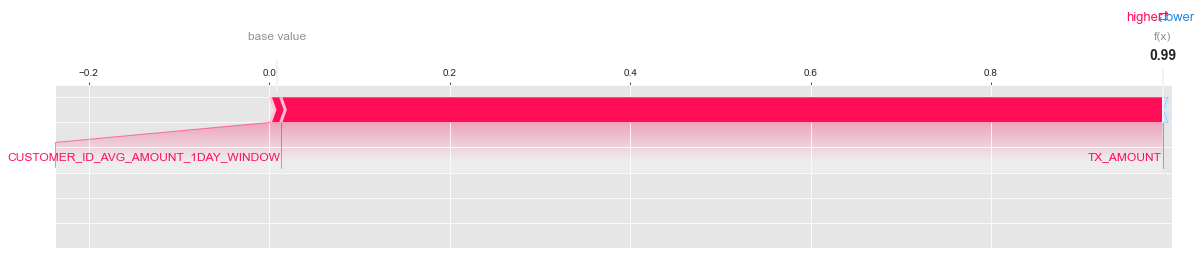

In [18]:
# First we focus on the first fraud of the list
sample = 0
shap.force_plot(expected_value, shap_values[1][sample], feature_names=input_features, matplotlib=True, link='identity')

On the force plot with this sample, we can see that the base value is around 0. The largest (negative) contribution is brought by `TX_AMOUNT`. On the contrary, the largest (positive) contribution is from `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW`. The output of the classifier for this sample is 0.01.

Now, if we call the force plot with multiple samples (here, the 1000 first frauds of the list), the previous plot is rotated by 90° and displayed for the multiple samples. Here is an example. This plot is interactive, and the SHAP explanation can, for instance, be sorted by similarity. This can be very useful to discover clusters among the SHAP values. 

In [19]:
shap_values = explainer_shap.shap_values(X=test1[input_features].iloc[0:1000,:])[1]
shap.force_plot(explainer_shap.expected_value[1], shap_values, feature_names=input_features)

The flat line around zero is the expected value, the positive contribution are in red, and the negative contribution are in blue. The predicted value is placed where the positive and negative effects meet each other. Here we can clearly see a cluster of transactions flagged as frauds because of `TX_AMOUNT` (scenario 1), followed by transactions flagged as frauds because of features `TX_AMOUNT` and `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW`. Most of the rest of the transaction are false negative transactions.

We will now check a transaction predicted as fraudulent: 

If we want to go to a more global level (see what happens for all samples or a cluster or samples), the SHAP summary plot can be used. Each point on the summary plot is a SHAP value, on the x-axis, for a certain feature and a certain instance. The colormap represents the actual value (not SHAP value) of the feature from the lower value in the dataset (in blue) to the highest (in red). On the y-axis, the features are ordered from larger importance (top) to smaller importance (bottom). SHAP importance is defined as follows: This is a global value for each feature; the absolute SHAP values are just summed per feature across all samples.

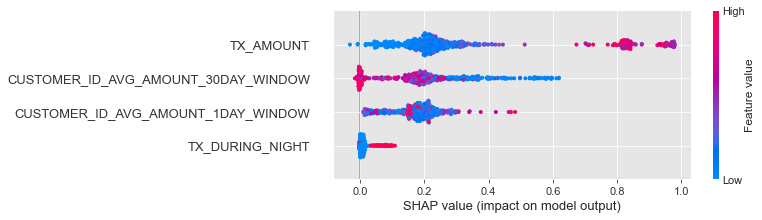

In [20]:
# shap's summary_plot 
shap_values = explainer_shap.shap_values(X=train1[input_features])[1]
shap.summary_plot(shap_values, train1[input_features], feature_names=input_features)  

From that plot, the features are sorted from the largest effect (on the top) to the smallest (which here is `TX_DURING_NIGHT`). Recall the SHAP values are additive and sum to the actual predicted value of the model. Once again, a high `TX_Amount` value implies a high probability of fraud (contrary to PDP/ICE/ALE, it is difficult to see the actual threshold is 220). For `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW`, we see that large SHAP value is correlated to low `CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW` value, but this is not the case for `CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW`. Finally, `TX_DURING_NIGHT` has almost no effect.